<a href="https://colab.research.google.com/github/Rouic/classification-experiment-ml/blob/main/Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:

!python3 --version


Python 3.10.12


In [5]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split


class TreeClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc = nn.Linear(768, num_classes)  # Adjust input size if using different embeddings

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # [CLS] token representation
        logits = self.fc(pooled_output)
        return logits

In [6]:
# UTILS
from timeit import default_timer as timer

def print_train_time(start, end, device=None):
    """ Print traing time """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [7]:

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:

texts = ["example text 1 y", "example text 2 y", "example text 3 g", "example text 4 g", "example text 5 p", "example text 6 p", "example text 6 y"]

labels = [0, 0, 1, 1, 2, 2, 0]

label_names = [
    "y class",
    "g class",
    "p class"
]

X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

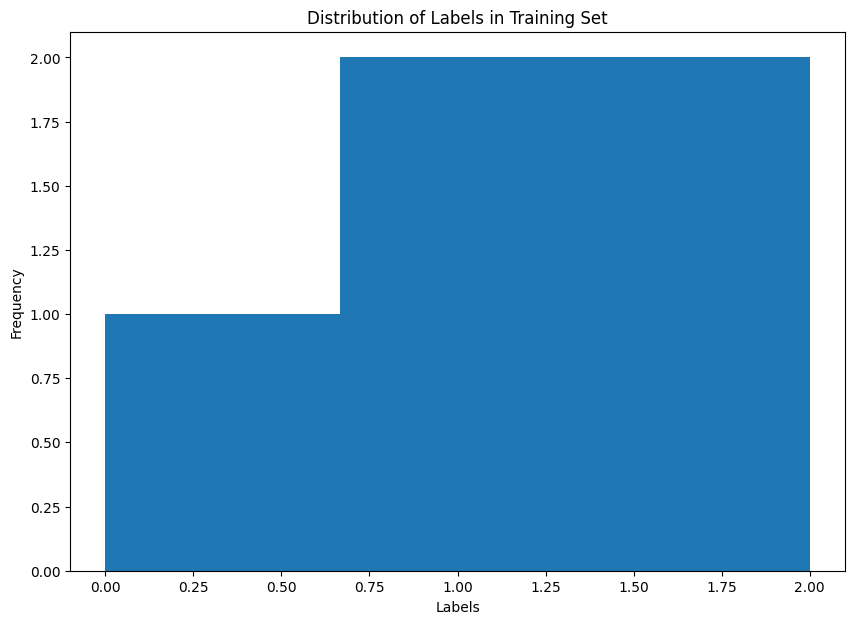

In [9]:
# Plot the data
# Assuming 'X_train' contains text data and is not suitable for direct plotting
# Instead, we can plot the distribution of labels in the training set
plt.figure(figsize=(10, 7))
plt.hist(y_train, bins=len(set(y_train))) # Plot histogram of labels
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels in Training Set')
plt.show()

In [10]:
# Define Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [11]:

# Example Usage
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset = TextDataset(X_train, y_train, tokenizer, max_len=128)
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

model = TreeClassifier(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

epochs = 100

start = timer()


for epoch in range(epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in data_loader:
        # Retrieve data from batch
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass: Get predictions from the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)  # Shape: [batch_size, num_classes]

        # Collect predictions and true labels
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)  # Store all predictions
        all_labels.extend(labels.cpu().numpy())  # Store all true labels

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass: Optimize the model
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update weights

        total_loss += loss.item()

    # Calculate overall accuracy for the epoch
    epoch_accuracy = accuracy_score(all_labels, all_preds)

    # Logging the loss and accuracy for this epoch
    avg_loss = total_loss / len(data_loader)
    if epoch % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {epoch_accuracy:.2%}")

end = timer()
print_train_time(start, end, device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/100, Loss: 1.1348, Accuracy: 40.00%
Epoch 11/100, Loss: 0.6984, Accuracy: 100.00%
Epoch 21/100, Loss: 0.2728, Accuracy: 100.00%
Epoch 31/100, Loss: 0.1648, Accuracy: 100.00%
Epoch 41/100, Loss: 0.0903, Accuracy: 100.00%
Epoch 51/100, Loss: 0.0588, Accuracy: 100.00%
Epoch 61/100, Loss: 0.0403, Accuracy: 100.00%
Epoch 71/100, Loss: 0.0284, Accuracy: 100.00%
Epoch 81/100, Loss: 0.0239, Accuracy: 100.00%
Epoch 91/100, Loss: 0.0213, Accuracy: 100.00%
Train time on cuda: 13.792 seconds


13.791932409000026

In [12]:
test_dataset = TextDataset(X_test, y_test, tokenizer, max_len=128)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [13]:
model.eval()
# Store predictions and true labels
all_predictions = []
all_labels = []

with torch.no_grad():  # Disable gradient computation
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)  # Shape: [batch_size, num_classes]
        predictions = torch.argmax(outputs, dim=1)  # Get predicted class (index of max logit)

        # Collect results
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [19]:
def predict_single_text(model, tokenizer, text, max_len=128):
    model.eval()
    with torch.no_grad():
        # Tokenize input text
        encoding = tokenizer(
            text,
            max_length=max_len,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # Get prediction
        output = model(input_ids=input_ids, attention_mask=attention_mask)
        predicted_class = torch.argmax(output, dim=1).item()

    return predicted_class

# Example
text = "p test"
predicted_class = predict_single_text(model, tokenizer, text)
print(f"Predicted Class: {predicted_class}, label: {label_names[predicted_class]}")


Predicted Class: 2, label: p class


In [20]:
# Predict tect with probability
def predict_single_text_probablity(model, tokenizer, text, max_len=128, device='cuda'):
    model.eval()
    with torch.no_grad():
        # Tokenize input text
        encoding = tokenizer(
            text,
            max_length=max_len,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # Get prediction
        output = model(input_ids=input_ids, attention_mask=attention_mask)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0, predicted_class].item()

    return predicted_class, confidence, probabilities.cpu().numpy()

# Example Usage
text = "p test"
predicted_class, confidence, probabilities = predict_single_text_probablity(model, tokenizer, text)
print(f"Predicted Class: {predicted_class}, Label: {label_names[predicted_class]}, Confidence: {confidence:.2f}")


Predicted Class: 2, Label: p class, Confidence: 0.87
